In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from useful_functions.plotter import plot

In [51]:
populations = pd.read_csv('../data/US_States/TrackTheRecovery/GeoIDs - State.csv', index_col='statefips')
case_data = pd.read_csv('../DL/data/states_unstacked.csv')
case_data = case_data[case_data['date'] <= '2021-02-25']
case_data = case_data.rename(columns={'Unnamed: 0': "statefips"})
case_data = case_data.sort_values(['date','statefips'])
iso_index = pd.read_csv('../data/US_States/cleaned_data/mobility_pca_only.csv')
iso_index = iso_index.sort_values(['Date', 'statefips'])

state_ids = populations.index.values
dates = iso_index['Date'].unique()
dates.sort()

In [52]:
case_data

,statefips,date,Stringency,positiveIncrease,deathIncrease,hospitalizedIncrease,totalTestsPeopleViralIncrease
0,1,2020-02-01,0.00,0.0,0.0,0.0,0.0
395,2,2020-02-01,5.56,0.0,0.0,0.0,0.0
790,4,2020-02-01,5.56,0.0,0.0,0.0,0.0
1185,5,2020-02-01,0.00,0.0,0.0,0.0,0.0
1580,6,2020-02-01,2.78,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
18165,51,2021-02-25,62.04,2036.0,156.0,73.0,0.0
18560,53,2021-02-25,65.74,872.0,31.0,51.0,0.0
19350,54,2021-02-25,49.07,431.0,5.0,0.0,0.0
19745,55,2021-02-25,56.02,965.0,58.0,61.0,13177.0


In [53]:
iso_index

,Unnamed: 0,statefips,statename,Date,shadow_index_normalized
0,0,1,Alabama,2020-02-01,3.470011
1,1,2,Alaska,2020-02-01,5.633745
2,2,4,Arizona,2020-02-01,3.786875
3,3,5,Arkansas,2020-02-01,2.984032
4,4,6,California,2020-02-01,3.781656
...,...,...,...,...,...
19936,19936,51,Virginia,2021-02-25,54.487582
19937,19937,53,Washington,2021-02-25,33.655507
19938,19938,54,West Virginia,2021-02-25,40.557192
19939,19939,55,Wisconsin,2021-02-25,46.619273


In [66]:
str(np.datetime64(dates[0]) + np.timedelta64(7,'D'))

'2020-02-08'

In [69]:
result = pd.DataFrame(index=dates)
corr = np.zeros(len(result))

lag = 14

# how does stringency correlate with future social distancing

for i,date in enumerate(dates[:-lag]):
    forward_date = str(np.datetime64(date) + np.timedelta64(lag,'D'))
    strin = case_data.loc[case_data['date'] == date]['Stringency'].values
    iso = iso_index.loc[iso_index['Date'] == forward_date]['shadow_index_normalized'].values
    assert np.all(iso_index.loc[iso_index['Date'] == forward_date]['statefips'].values == case_data.loc[case_data['date'] == date]['statefips'].values)
    corr[i] = np.corrcoef(strin, iso)[0][1]
    
result['corr'] = corr

Text(0, 0.5, 'Correlation between SD index and Stringency')

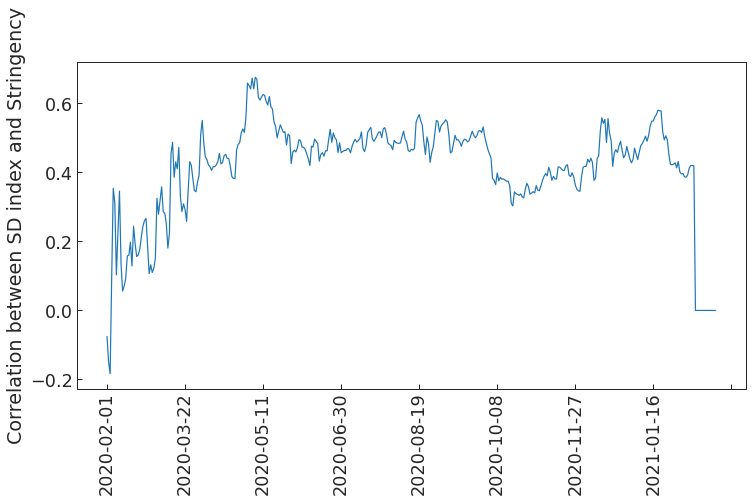

In [72]:
result['corr'].plot(figsize=(12,6))
plt.xticks(rotation = 90)
plt.ylabel('Correlation between SD index and Stringency')

In [130]:
# how predictive is our index on future case growth (or death/hospitalization?)
# how predictive is the stringency on future case growth (or death/hospitalization?)

# for each state, correlate our index with 

result = pd.DataFrame(index=state_ids)
corr_str = np.zeros(len(result))
corr_ind = np.zeros(len(result))

lag = 14
metric = 'hospitalizedIncrease'

# how does stringency correlate with future social distancing

for i,state in enumerate(state_ids): # dates[:-lag]
    
    strin = case_data.loc[case_data['statefips'] == state, 'Stringency'] # stringency
    case_met = case_data.loc[case_data['statefips'] == state, metric] # metric
    iso = iso_index.loc[iso_index['statefips'] == state, 'shadow_index_normalized']
    corr_ind[i] = iso.shift(lag).corr(case_met)  # correlates current isolation index with N-day future cases
    corr_str[i] = strin.shift(lag).corr(case_met) # correlates current stringency with N-day future cases
    
    assert np.all(iso_index.loc[iso_index['statefips'] == state, 'statefips'].values == case_data.loc[case_data['statefips'] == state, 'statefips'].values)
    
    
result['corr_str'] = corr_str
result['corr_ind'] = corr_ind

Text(0, 0.5, 'Number of states')

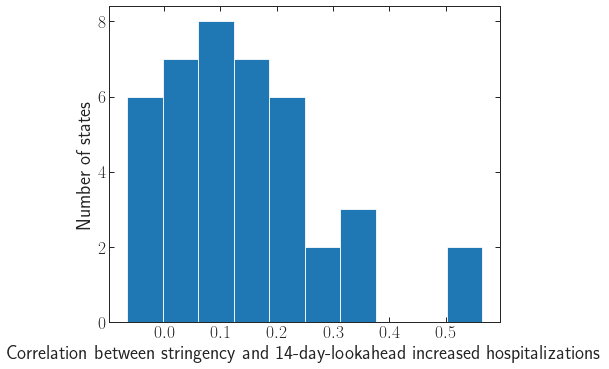

In [134]:
fig,ax = plot()

plt.hist(result['corr_str'])
plt.xlabel(r'Correlation between stringency and 14-day-lookahead increased hospitalizations')
plt.ylabel(r'Number of states')

Text(0, 0.5, 'Number of states')

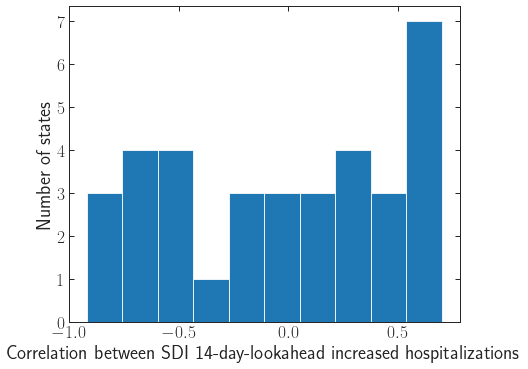

In [133]:
fig,ax = plot()

plt.hist(result['corr_ind'])
plt.xlabel(r'Correlation between SDI and 14-day-lookahead increased hospitalizations')
plt.ylabel(r'Number of states')